In [2]:
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 24.8 MB/s eta 0:00:00


In [3]:
# Load panda library & read data set
import pandas as pd
friends_data = pd.read_csv("scan_chat-bot.csv")

# Preview data
friends_data.head()

,Unnamed: 0,auteur,contenu,heure_date,channel,mentions,user_respond
0,0,nildra,!scan,2024-03-27 00:45:11,chat-bot,NONE,NONE
1,1,nildra,!scan,2024-03-27 00:45:08,chat-bot,NONE,NONE
2,2,nildra,!scan,2024-03-27 00:43:51,chat-bot,NONE,NONE
3,3,nildra,!scan,2024-03-27 00:42:25,chat-bot,NONE,NONE
4,4,nildra,!scan,2024-03-27 00:39:48,chat-bot,NONE,NONE


In [4]:
# Remove unused columns
# friends_data = friends_data.drop(columns=['scene','utterance'], axis=1)
# friends_data.head()

# Import libraries, classes & datasets
import re
import nltk

from gensim.parsing.preprocessing import STOPWORDS
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Initialize the Porter Stemmer and WordNet Lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Gensim stopwords
gensim_stop_words = set(stopwords.words('french'))

# Remove punctuations, stopwords, convert to lowercase, tokenize, stem, and lemmatize
def preprocess_text(text):
    cleaned_text = re.sub(r'[^\w\s]', '', text) # remove all non-word and non-whitespace characters from the text
    stop_words = set(gensim_stop_words)
    words = word_tokenize(cleaned_text.lower())
    filtered_words = [word for word in words if word not in stop_words and len(word) >= 4] # remove words have less than 4 characters
    stemmed_words = [stemmer.stem(word) for word in filtered_words]
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stemmed_words]
    return lemmatized_words

# Apply preprocessing to the 'text' column
friends_data['processed_text'] = friends_data['contenu'].apply(preprocess_text)
friends_data.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,Unnamed: 0,auteur,contenu,heure_date,channel,mentions,user_respond,processed_text
0,0,nildra,!scan,2024-03-27 00:45:11,chat-bot,NONE,NONE,[scan]
1,1,nildra,!scan,2024-03-27 00:45:08,chat-bot,NONE,NONE,[scan]
2,2,nildra,!scan,2024-03-27 00:43:51,chat-bot,NONE,NONE,[scan]
3,3,nildra,!scan,2024-03-27 00:42:25,chat-bot,NONE,NONE,[scan]
4,4,nildra,!scan,2024-03-27 00:39:48,chat-bot,NONE,NONE,[scan]


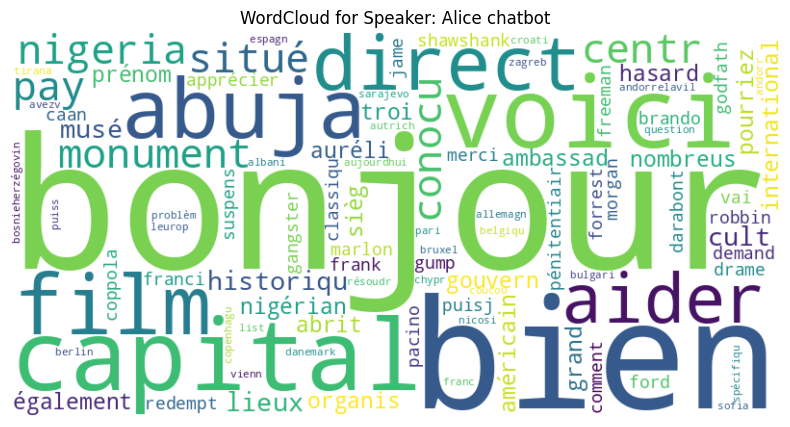

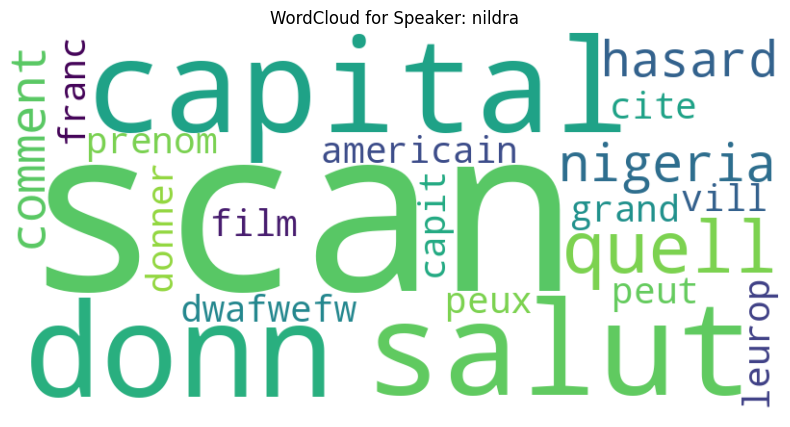

In [5]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Function to generate WordCloud for a specific speaker
def generate_wordcloud_for_speaker(speaker_name, text_data):

    # Combine all text data for the specific speaker and join tokens into a single string
    speaker_text = ' '.join(' '.join(tokens) for tokens in text_data[text_data['auteur'] == speaker_name]['processed_text'])

    # Create WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(speaker_text)

    # Plot the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud for Speaker: {speaker_name}')
    plt.show()

# List of specific speakers to visualize
speakers_to_visualize = ["Alice chatbot", "nildra"]

# Plot the WordCloud for each character
for speaker_name in speakers_to_visualize:
    generate_wordcloud_for_speaker(speaker_name, friends_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Optimal Number of Topics: 8
Coherence Score for Optimal Number of Topics: 0.7004907762238732


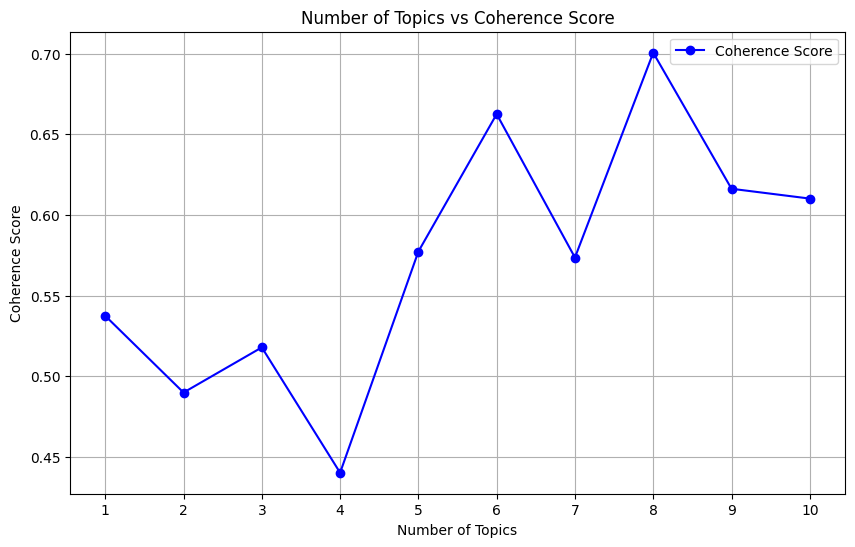

In [10]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from pprint import pprint
import numpy as np

# Create a Dictionary from the tokenized text data
id2word = Dictionary(friends_data['processed_text'])

# Term Document Frequency
corpus = [id2word.doc2bow(tokens) for tokens in friends_data['processed_text']]

# Specify the range of number of topics to search within
min_topics = 1
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics+1, step_size)

# Perform Grid Search and compute coherence scores for different number of topics
from gensim.models.coherencemodel import CoherenceModel

coherence_scores = []
for num_topics in topics_range:
    lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=friends_data['processed_text'], dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_scores.append(coherence_lda)

# Find the optimal number of topics with the highest coherence score
optimal_num_topics = topics_range[np.argmax(coherence_scores)]
print("Optimal Number of Topics:", optimal_num_topics)
print("Coherence Score for Optimal Number of Topics:", max(coherence_scores))

# Plotting the relationship between the number of topics and coherence score
plt.figure(figsize=(10, 6))
plt.plot(topics_range, coherence_scores, marker='o', color='b', label='Coherence Score')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Number of Topics vs Coherence Score')
plt.xticks(topics_range)
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Number of topics for the LDA model
num_topics = 3

# Build the LDA model
lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)

# Print the topics
pprint(lda_model.print_topics())

# import the CoherenceModel class from the Gensim library
from gensim.models.coherencemodel import CoherenceModel

# compute Coherence Score
coherence_model = CoherenceModel(model=lda_model, texts=friends_data['processed_text'], dictionary=id2word, coherence='c_v')
coherence_score = coherence_model.get_coherence()

# print out result
print(f'Coherence Score: {coherence_score}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.067*"scan" + 0.038*"salut" + 0.037*"comment" + 0.028*"capital" + '
  '0.027*"aider" + 0.019*"bonjour" + 0.016*"donn" + 0.016*"bien" + '
  '0.016*"leurop" + 0.016*"quell"'),
 (1,
  '0.038*"capital" + 0.023*"bonjour" + 0.020*"bien" + 0.020*"nigeria" + '
  '0.019*"abuja" + 0.015*"voici" + 0.014*"donn" + 0.014*"hasard" + '
  '0.012*"franc" + 0.012*"copenhagu"'),
 (2,
  '0.030*"hasard" + 0.030*"film" + 0.026*"grand" + 0.025*"voici" + '
  '0.020*"bien" + 0.019*"prénom" + 0.019*"auréli" + 0.019*"cite" + '
  '0.019*"americain" + 0.018*"scan"')]
Coherence Score: 0.47021647959602353


In [12]:
import pyLDAvis.gensim
import pickle
import pyLDAvis
import os

# Create the 'results' directory if it doesn't exist
os.makedirs('results', exist_ok=True)

# Prepare the LDA visualization data
LDAvis_data_filepath = './results/ldavis_prepared_' + str(num_topics) + '.pkl'

# If you haven't prepared the visualization data, create it
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# Save the interactive visualization as an HTML file
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_' + str(num_topics) + '.html')

# Print a message indicating where the HTML file is saved
print(f"Interactive LDA visualization saved as 'ldavis_prepared_{num_topics}.html'")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Interactive LDA visualization saved as 'ldavis_prepared_3.html'
